In [1]:
import numpy as np
import pandas as pd
import sys
import json
import os
import copy
import matplotlib.pyplot as plt

Make `WMPL` directory visible:

In [2]:
sys.path.append('../../')

Import WMPL files:

In [3]:
import source.WesternMeteorPyLib.wmpl.MetSim.MetSim as metsim
import source.WesternMeteorPyLib.wmpl.MetSim.FitSim as fitsim
import source.WesternMeteorPyLib.wmpl.MetSim.GUI as gui
import source.WesternMeteorPyLib.wmpl.MetSim.MetSimErosion as erosion

In [4]:
class MetSimObj():
    def __init__(self, traj_path, const_json_file):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # run the simulation
        self.runSimulationGUI(const_json)


    def runSimulationGUI(self, const_json):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            if self.const.fragmentation_on and (self.fragmentation is None):
                frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
                    "Fragmentation is enabled but no fragmentation file is set.")
                frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
                frag_error_message.exec_()
                return None   
            # Load fragmentation entries if fragmentation is enabled
            if self.const.fragmentation_on:
    
                # Load the file
                self.fragmentation.loadFragmentationFile()
    
                # Sort entries by height
                self.fragmentation.sortByHeight()
    
                # Reset the status of all fragmentations
                self.fragmentation.resetAll()
    
                # Write the fragmentation file
                # self.fragmentation.writeFragmentationFile()
            # Store previous run results
            # self.const_prev = copy.deepcopy(self.const)
            # self.simulation_results_prev = copy.deepcopy(self.simulation_results)

            #### TODO: replace readinputboxes with reading the values from the json

            self.const.dt = const_json.get('dt')
            self.const.P_0m = const_json.get('P_0m')
            self.const.h_init = const_json.get('h_init')
            self.const.m_kill = const_json.get('m_kill')
            self.const.v_kill = const_json.get('v_kill')
            self.const.h_kill = const_json.get('h_kill')
            self.const.len_kill = const_json.get('len_kill')
            self.const.rho = const_json.get('rho')
            self.const.rho_grain = const_json.get('rho_grain')
            self.const.m_init = const_json.get('m_init')
            self.const.sigma = const_json.get('sigma')
            self.const.v_init = const_json.get('v_init')
            self.const.shape_factor = const_json.get('shape_factor')
            self.const.gamma = const_json.get('gamma')
            self.const.zenith_angle = const_json.get('zenith_angle')
            self.const.lum_eff = const_json.get('lum_eff')
            self.const.lum_eff_type = const_json.get('lum_eff_type')
            self.const.erosion_height_start = const_json.get('erosion_height_start')
            self.const.erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
            self.const.erosion_coeff = const_json.get('erosion_coeff')
            self.const.erosion_height_change = const_json.get('erosion_height_change')
            self.const.erosion_coeff_change = const_json.get('erosion_coeff_change')
            self.const.erosion_mass_index = const_json.get('erosion_mass_index')
            self.const.erosion_mass_min = const_json.get('erosion_mass_min')
            self.const.erosion_mass_max = const_json.get('erosion_mass_max')
            self.const.erosion_rho_change = const_json.get('rho')
            self.const.erosion_sigma_change = const_json.get('sigma')
            self.const.compressive_strength = const_json.get('compressive_strength')
            self.const.disruption_erosion_coeff = const_json.get('erosion_coeff')
            self.const.disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
            self.const.disruption_mass_index = const_json.get('disruption_mass_index')
            self.const.disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
            self.const.disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')
            # fragmentation
            self.const.fragmentation_on = const_json.get('fragmentation_on')
    
            # # Disable the simulation button (have to force update by calling "repaint")
            # self.runSimButton.setStyleSheet("background-color: red")
            # self.runSimButton.setDisabled(True)
            # self.repaint()
            # print('Running simulation...')
            # t1 = time.time()
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)
    
            # # Save simulated parametrs to file
            # self.simulation_results.writeCSV(self.dir_path, SIM_RESULTS_CSV)
            # print("Saved simulation results to:", os.path.join(self.dir_path, SIM_RESULTS_CSV))
    
            # # Toggle lum eff button to only be available if lum eff was computed
            # self.plotLumEffButton.setDisabled(not self.const.fragmentation_show_individual_lcs)
    
            # # Write results in the fragmentation file
            # if self.const.fragmentation_on:
            #     self.fragmentation.writeFragmentationFile()
    
            # # Update the plots
            # self.showCurrentResults()
    
            # # Save the latest run parameters
            # self.saveFitParameters(False, suffix="_latest")
    
            # # Enable the simulation button
            # self.runSimButton.setDisabled(False)
            # self.runSimButton.setStyleSheet("background-color: #b1eea6")

Test with 1999 event:

In [5]:
metsim_obj = MetSimObj(traj_path='../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', 
                       const_json_file='../usg_metsim_files/1999-01-14/usg_input_jan_1999_sim_fit.json')

/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:1559: RuntimeWarning: invalid value encountered in log10
  data.absolute_magnitudes = -2.5*np.log10(data.usg_intensity_data[:, 1]/248)
/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:95: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_main = -2.5*np.log10(self.luminosity_main_arr/self.const.P_0m)
/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:99: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_eroded = -2.5*np.log10(self.luminosity_eroded_arr/self.const.P_0m)


In [6]:
obs_data, obs_traj = gui.loadUSGInputFile('../usg_metsim_files/1999-01-14/', 'usg_input_jan_1999.txt')


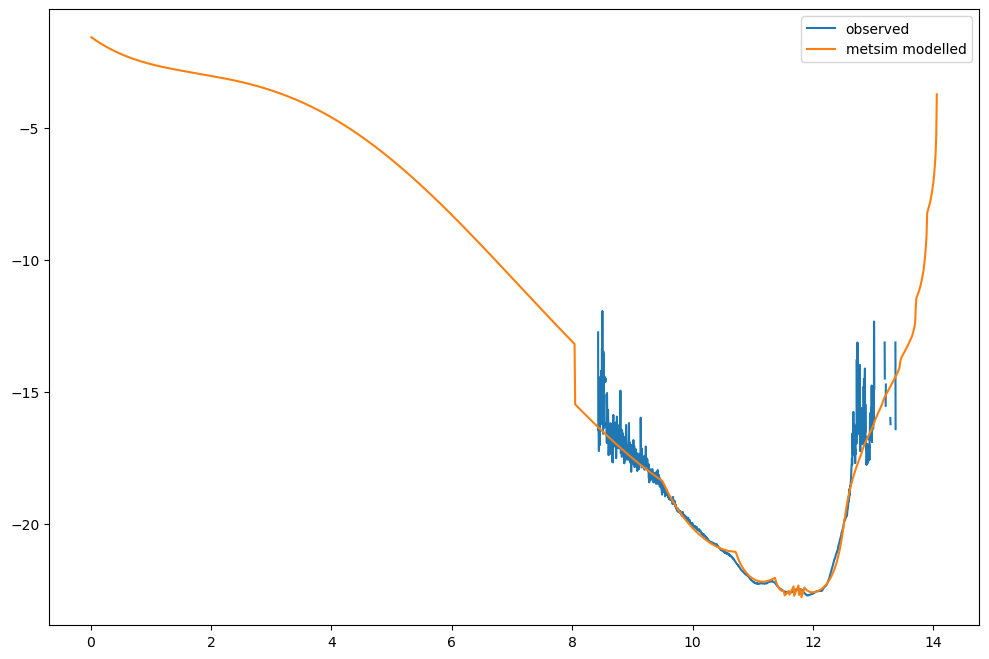

In [7]:
plt.figure(figsize = (12, 8))
plt.plot(metsim_obj.usg_data.time_data + 11.9, metsim_obj.usg_data.absolute_magnitudes, label = 'observed')
plt.plot(metsim_obj.simulation_results.time_arr, metsim_obj.simulation_results.abs_magnitude, label = 'metsim modelled')
plt.legend()

In [8]:
# gui.MetSimGUI.loadFragmentationFile()

# self.fragmentation=None

In [9]:
# gui.FragmentationContainer(gui.MetSimGUI('../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', usg_input=True), 
#                            '../usg_metsim_files/1999-01-14/metsim_fragmentation.txt')

In [10]:
# gui.MetSimGUI('../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', usg_input=True)